In [1]:
from typing import Final
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import chain
from numba import njit, vectorize, guvectorize, int64, float64

%matplotlib inline

In [2]:
#pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_excel('historyIndex.xls')
df = df.iloc[6:649].copy()

In [4]:
df.reset_index(drop=True, inplace=True)
df.columns = ['date', 'price']

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.replace(',','', regex=True)
df['price'] = df['price'].astype(float)

In [6]:
periods = ['1m', '3m', '6m', '1y', '2y', '3y', '5y', '10y', '20y', '30y']
durations = [1, 3, 6, 12, 24, 36, 60, 120, 240, 360]

In [7]:
@njit
def calculate_return(ending_index, dca_length, monthly_returns, investment_horizon=None):
    if investment_horizon is None:
        investment_horizon = dca_length
    elif investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    if ending_index < dca_length:
        return np.nan
    share_value = 0
    cash = 1
    for i in range(ending_index - investment_horizon, ending_index - investment_horizon + dca_length):
        cash -= 1/dca_length
        share_value += 1/dca_length
        share_value *= 1 + monthly_returns[i+1]
    for i in range(ending_index - investment_horizon + dca_length, ending_index):
        share_value *= 1 + monthly_returns[i+1]
    return share_value - 1

@guvectorize([(int64, float64[:], int64, float64[:])], '(),(n),()->(n)', target='parallel', nopython=True)
def calculate_return_vector(dca_length, monthly_returns, investment_horizon, res=np.array([])):
    if investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    for i in range(len(monthly_returns)):
        if i < investment_horizon:
            res[i] = np.nan
        share_value = 0
        cash = 1
        for j in range(i - investment_horizon, i - investment_horizon + dca_length):
            cash -= 1/dca_length
            share_value += 1/dca_length
            share_value *= 1 + monthly_returns[j+1]
        for j in range(i - investment_horizon + dca_length, i):
            share_value *= 1 + monthly_returns[j+1]
        res[i] = share_value - 1
        
@guvectorize([(float64, float64, float64, float64, int64, int64, int64, float64[:], float64[:])], '(),(),(),(),(),(),(),(n)->(n)', target='parallel', nopython=True)
def calculate_lumpsum_return_with_fees_vector(total_investment, variable_transaction_fees, fixed_transaction_fees, annualised_holding_fees, dca_length, dca_interval, investment_horizon, monthly_returns, res=np.array([])):
    if investment_horizon < dca_length:
        raise ValueError('Investment horizon must be greater than or equal to DCA length')
    if fixed_transaction_fees >= total_investment / dca_length * dca_interval:
        raise ValueError('Fixed fees must be less than the amount invested in each DCA')
    for i in range(len(monthly_returns)):
        if i < investment_horizon:
            res[i] = np.nan
        share_value = 0
        cash = total_investment
        dca_amount = total_investment / dca_length * dca_interval
        for j in range(i - investment_horizon, i - investment_horizon + dca_length, dca_interval):
            cash -= dca_amount
            share_value += dca_amount * (1 - variable_transaction_fees) - fixed_transaction_fees
            for k in range(j, j + dca_interval):
                share_value *= 1 + (monthly_returns[k+1] ** 12 - annualised_holding_fees) ** (1/12)
        if cash != 0.:
            share_value += cash * (1 - variable_transaction_fees) - fixed_transaction_fees
            cash-= cash
        for j in range(i - investment_horizon + dca_length, i):
            share_value *= 1 + (monthly_returns[j+1] ** 12 - annualised_holding_fees) ** (1/12)
        res[i] = (share_value - total_investment) / total_investment
        
@guvectorize([(float64, float64, float64, float64, int64, int64, float64[:], float64[:])], '(),(),(),(),(),(),(n)->(n)', target='parallel', nopython=True)
def calculate_dca_return_with_fees_vector(monthly_amount, variable_transaction_fees, fixed_transaction_fees, annualised_holding_fees, dca_length, dca_interval, monthly_returns, res=np.array([])):
    total_investment = monthly_amount * dca_length
    dca_amount = monthly_amount * dca_interval
    if fixed_transaction_fees >= dca_amount:
        raise ValueError('Fixed fees must be less than the amount invested in each DCA')
    for i in range(len(monthly_returns)):
        if i < dca_length:
            res[i] = np.nan
        share_value = 0
        amount_invested = 0
        for index, j in enumerate(range(i - dca_length, i)):
            if (index + 1) % dca_interval == 0:
                share_value += dca_amount * (1 - variable_transaction_fees) - fixed_transaction_fees
                amount_invested += dca_amount
            share_value *= 1 + (monthly_returns[j+1] ** 12 - annualised_holding_fees) ** (1/12)
        res[i] = (share_value - amount_invested) / total_investment


In [8]:
for period, duration in zip(periods, durations):
    df[f'{period}_cumulative'] = df['price'].pct_change(periods=duration)
for period, duration in zip(periods, durations):
    df[f'{period}_annualized'] = (1 + df[f'{period}_cumulative'])**(12/duration) - 1
for period, duration in zip(periods, durations):
    df[f'{period}_dca_cumulative'] = calculate_return_vector(duration, df['1m_cumulative'].values, duration)
for period, duration in zip(periods, durations):
    df[f'{period}_dca_annualized'] = (1 + df[f'{period}_dca_cumulative'])**(12/duration) - 1
for period, duration in zip(periods, durations):
    df[f'{period}_cumulative_difference'] = df[f'{period}_cumulative'] - df[f'{period}_dca_cumulative']
for period, duration in zip(periods, durations):
    df[f'{period}_difference_in_annualized'] = df[f'{period}_annualized'] - df[f'{period}_dca_annualized']
df = pd.concat([df, pd.DataFrame.from_dict({f'{i}m_dca_{period}_cumulative': calculate_return_vector(i, df['1m_cumulative'].values, duration) for period, duration in zip(periods, durations) for i in range(1, duration+1)})], axis=1)

In [9]:
pd.DataFrame({f'every {dca_interval} months': calculate_dca_return_with_fees_vector(1000, 0.0002, 5.73, 0, 120, dca_interval, df['1m_cumulative']) for dca_interval in range(1, 13)}).describe()

,every 1 months,every 2 months,every 3 months,every 4 months,every 5 months,every 6 months,every 7 months,every 8 months,every 9 months,every 10 months,every 11 months,every 12 months
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,0.719209,0.717192,0.711867,0.705743,0.699287,0.692738,0.686237,0.679282,0.672876,0.665796,0.658894,0.652317
std,0.511671,0.508822,0.505031,0.501006,0.496849,0.492697,0.488792,0.484594,0.480631,0.476018,0.472190,0.467934
min,-0.277830,-0.272524,-0.272744,-0.269722,-0.276371,-0.270037,-0.271198,-0.265790,-0.258994,-0.267274,-0.236126,-0.263068
25%,0.384356,0.385686,0.382624,0.382707,0.378243,0.369880,0.365383,0.370721,0.359691,0.357089,0.358222,0.354840
50%,0.611023,0.608371,0.604253,0.603993,0.594049,0.589642,0.582958,0.577979,0.566167,0.560058,0.554395,0.542628
75%,0.900734,0.892340,0.881869,0.873675,0.862956,0.853398,0.848641,0.835001,0.828436,0.819001,0.807358,0.800348
max,2.564219,2.556557,2.533407,2.528027,2.468734,2.471636,2.482803,2.461854,2.383421,2.383620,2.396824,2.371050


In [10]:
scaler = StandardScaler()

In [11]:
four_year_returns = pd.DataFrame.from_dict({f'{50000} invested over {dca_length} months every 3 months {48}-month return': calculate_lumpsum_return_with_fees_vector(50000, 0.0004, 5.73, 0, dca_length, 3, 48, df['1m_cumulative'].values) for dca_length in range(3, 49, 3)})

In [12]:
four_year_returns.describe()

,50000 invested over 3 months every 3 months 48-month return,50000 invested over 6 months every 3 months 48-month return,50000 invested over 9 months every 3 months 48-month return,50000 invested over 12 months every 3 months 48-month return,50000 invested over 15 months every 3 months 48-month return,50000 invested over 18 months every 3 months 48-month return,50000 invested over 21 months every 3 months 48-month return,50000 invested over 24 months every 3 months 48-month return,50000 invested over 27 months every 3 months 48-month return,50000 invested over 30 months every 3 months 48-month return,50000 invested over 33 months every 3 months 48-month return,50000 invested over 36 months every 3 months 48-month return,50000 invested over 39 months every 3 months 48-month return,50000 invested over 42 months every 3 months 48-month return,50000 invested over 45 months every 3 months 48-month return,50000 invested over 48 months every 3 months 48-month return
count,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000,595.000000
mean,0.476107,0.458452,0.440526,0.423254,0.406193,0.389279,0.372842,0.356775,0.340615,0.324965,0.309229,0.293841,0.278716,0.263883,0.249320,0.235102
std,0.477441,0.458803,0.440640,0.423608,0.407329,0.391545,0.376097,0.360890,0.346107,0.331739,0.317275,0.302761,0.288152,0.273546,0.259027,0.244568
min,-0.337750,-0.352906,-0.354899,-0.378982,-0.394608,-0.401788,-0.402636,-0.398326,-0.384784,-0.395378,-0.405414,-0.415165,-0.419615,-0.425528,-0.426372,-0.409483
25%,0.152682,0.159203,0.161386,0.169954,0.174933,0.183279,0.175852,0.164192,0.157901,0.145592,0.132058,0.124577,0.115968,0.104905,0.099060,0.091428
50%,0.431915,0.414218,0.406323,0.388557,0.377854,0.364218,0.353544,0.343101,0.327801,0.313854,0.298259,0.286009,0.272002,0.257129,0.241779,0.226589
75%,0.653580,0.642593,0.617584,0.580187,0.559473,0.544249,0.523811,0.508700,0.487162,0.465866,0.450222,0.433692,0.418800,0.397063,0.375354,0.355675
max,2.060354,2.009992,1.988836,2.005677,1.975299,1.953438,1.908345,1.849115,1.790489,1.719004,1.634457,1.547667,1.459173,1.385063,1.306557,1.229547


<Axes: >

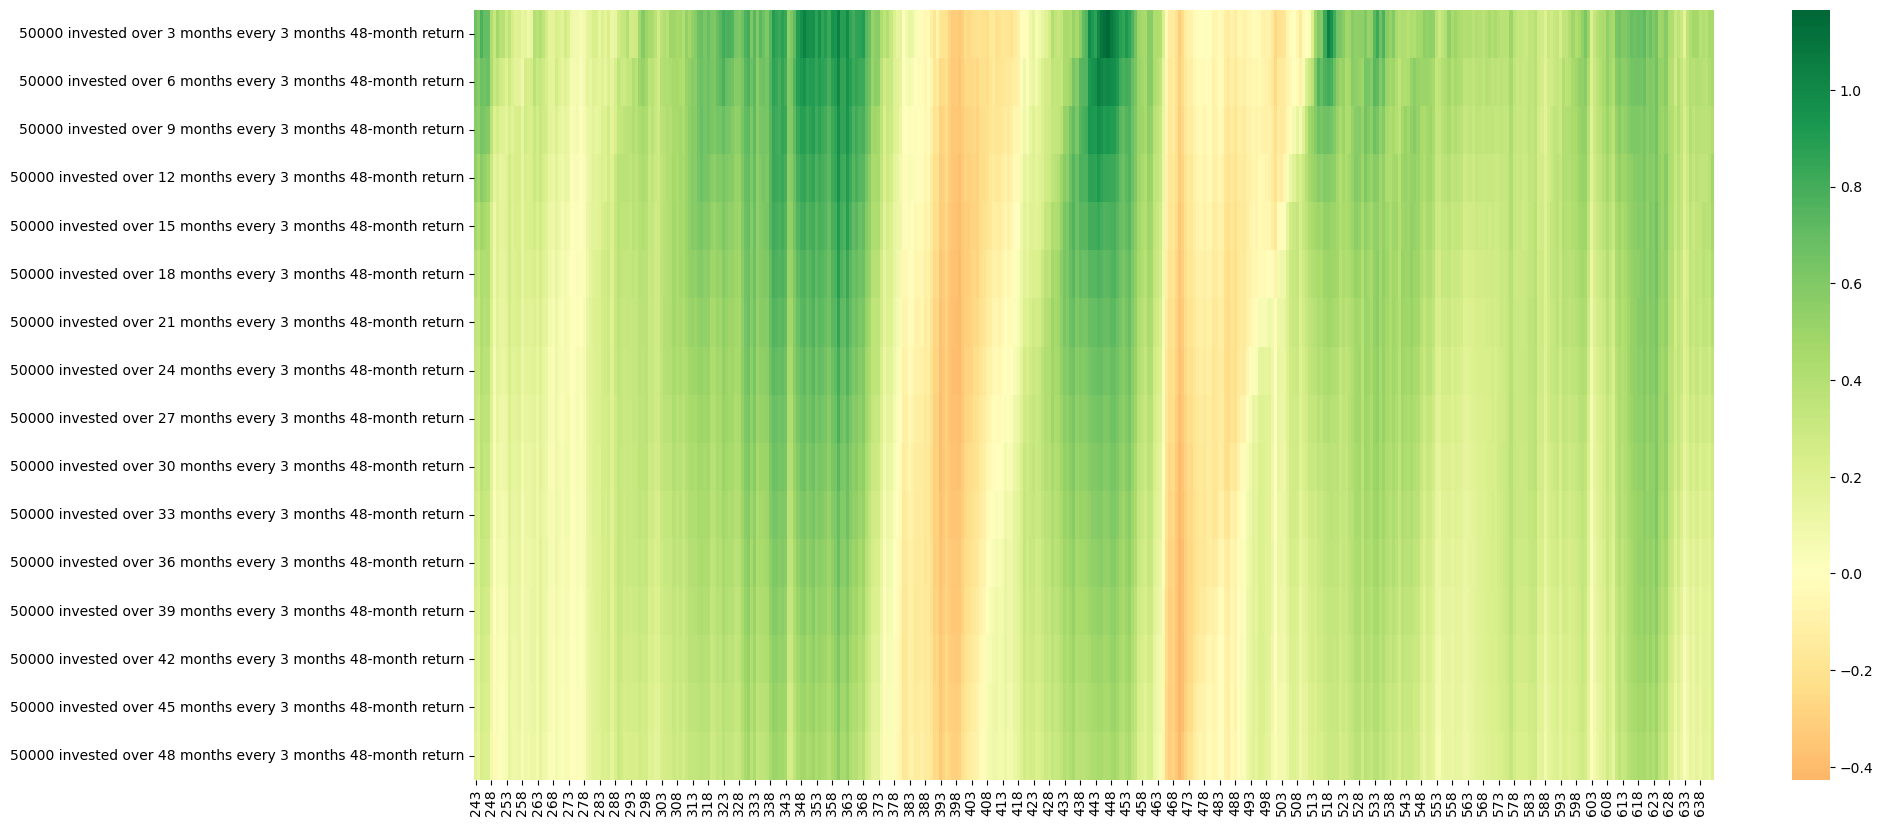

In [13]:
plt.figure(figsize=(20, 10))
sns.heatmap(four_year_returns.tail(400).T, cmap='RdYlGn', center=0)

In [14]:
df.head(10)

,date,price,1m_cumulative,3m_cumulative,6m_cumulative,1y_cumulative,2y_cumulative,3y_cumulative,5y_cumulative,10y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
0,1969-12-31,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-01-30,94.455,-0.055450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-02-27,97.405,0.031232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-03-31,97.708,0.003111,-0.022920,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-04-30,88.578,-0.093442,-0.062220,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1970-05-29,82.990,-0.063086,-0.147990,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1970-06-30,80.946,-0.024629,-0.171552,-0.190540,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1970-07-31,85.965,0.062004,-0.029499,-0.089884,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1970-08-31,88.799,0.032967,0.069996,-0.088353,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1970-09-30,91.667,0.032298,0.132446,-0.061827,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.describe()

,price,1m_cumulative,3m_cumulative,6m_cumulative,1y_cumulative,2y_cumulative,3y_cumulative,5y_cumulative,10y_cumulative,20y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
count,643.000000,642.000000,640.000000,637.000000,631.000000,619.000000,607.000000,583.000000,523.000000,403.000000,...,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,2198.926684,0.008004,0.024388,0.050237,0.103904,0.220662,0.343141,0.632624,1.673092,5.878773,...,3.875219,3.864357,3.853540,3.842767,3.832039,3.821354,3.810713,3.800114,3.789559,3.779048
std,2283.652576,0.043099,0.077180,0.115255,0.171518,0.271936,0.363582,0.597454,1.179074,3.907376,...,2.047354,2.041545,2.035765,2.030015,2.024293,2.018602,2.012941,2.007313,2.001716,1.996152
min,80.946000,-0.189601,-0.332204,-0.435526,-0.471197,-0.474002,-0.456299,-0.253635,-0.227533,0.884585,...,1.692774,1.687572,1.682387,1.677282,1.672155,1.666996,1.661803,1.656573,1.651386,1.646431
25%,260.186500,-0.016661,-0.012940,-0.014153,0.007124,0.078832,0.157988,0.210823,0.876383,2.541515,...,2.384477,2.377924,2.371389,2.365003,2.358506,2.352102,2.345851,2.339523,2.333099,2.326746
50%,1523.547000,0.011799,0.027616,0.053283,0.120567,0.241031,0.321033,0.567305,1.335702,4.717338,...,2.822881,2.813910,2.805001,2.796160,2.787274,2.778411,2.769751,2.761187,2.752699,2.744526
75%,3189.356500,0.032662,0.070384,0.112893,0.200181,0.363260,0.519703,0.860468,2.284508,8.802631,...,5.480647,5.465418,5.450195,5.435077,5.419987,5.404932,5.389861,5.374803,5.359795,5.344845
max,9755.694000,0.145823,0.304416,0.466621,0.659709,1.372536,1.969380,3.263036,5.219628,16.582382,...,10.974358,10.943767,10.913220,10.882971,10.852741,10.822691,10.792816,10.763139,10.733468,10.703877


In [16]:
df.loc[:,'1m_dca_30y_cumulative':]

,1m_dca_30y_cumulative,2m_dca_30y_cumulative,3m_dca_30y_cumulative,4m_dca_30y_cumulative,5m_dca_30y_cumulative,6m_dca_30y_cumulative,7m_dca_30y_cumulative,8m_dca_30y_cumulative,9m_dca_30y_cumulative,10m_dca_30y_cumulative,...,351m_dca_30y_cumulative,352m_dca_30y_cumulative,353m_dca_30y_cumulative,354m_dca_30y_cumulative,355m_dca_30y_cumulative,356m_dca_30y_cumulative,357m_dca_30y_cumulative,358m_dca_30y_cumulative,359m_dca_30y_cumulative,360m_dca_30y_cumulative
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,7.997696,7.752341,7.545670,7.397050,7.321748,7.244896,7.141037,7.081065,7.011786,7.001275,...,2.282342,2.275809,2.269578,2.263158,2.256897,2.250970,2.244862,2.238593,2.232483,2.226215
639,7.769850,7.576732,7.450114,7.404679,7.344448,7.245404,7.195774,7.132301,7.134378,7.098196,...,2.360226,2.353831,2.347242,2.340816,2.334736,2.328468,2.322034,2.315764,2.309330,2.303001
640,7.530575,7.435570,7.428150,7.382507,7.283214,7.242085,7.182181,7.196143,7.164217,7.089903,...,2.396921,2.390242,2.383729,2.377570,2.371218,2.364697,2.358342,2.351821,2.345406,2.338940
641,7.257299,7.293308,7.249958,7.139296,7.102680,7.043010,7.067018,7.037373,6.960664,6.909096,...,2.341897,2.335473,2.329398,2.323133,2.316699,2.310431,2.303997,2.297669,2.291289,2.284897


In [17]:
percentiles = df.loc[:,'1m_dca_30y_cumulative':'36m_dca_30y_cumulative'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]).T.reset_index(drop=True)

In [18]:
percentiles.index += 1

In [19]:
percentiles

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
1,5.497488,6.098815,8.464196,13.732866,18.813072,26.848220,33.491748
2,5.384825,6.034232,8.346706,13.608795,18.751831,26.740280,32.484861
3,5.361035,5.991120,8.264424,13.598818,18.869930,26.759701,31.978577
4,5.325143,5.986205,8.200902,13.587699,19.010750,26.592033,32.235178
5,5.262971,6.006122,8.121406,13.508181,19.267192,26.634490,32.322442
6,5.325407,5.957106,8.076169,13.421533,19.250993,26.443166,32.201514
7,5.353064,5.922910,7.973176,13.311001,19.341332,26.288749,31.969442
8,5.283101,5.930142,7.958773,13.217362,19.290628,26.031438,31.854521
9,5.244815,5.959125,7.921462,13.144687,19.484204,25.921102,31.687117
10,5.198024,5.986961,7.886329,13.057928,19.575222,25.734950,31.405116


In [20]:
px.line(percentiles.iloc[:,0], log_y=True)

In [21]:
df.loc[:, [*df.loc[:,'1m_annualized':'30y_annualized'].columns, *df.loc[:,'1m_dca_annualized':'30y_dca_annualized']]].describe()

,1m_annualized,3m_annualized,6m_annualized,1y_annualized,2y_annualized,3y_annualized,5y_annualized,10y_annualized,20y_annualized,30y_annualized,1m_dca_annualized,3m_dca_annualized,6m_dca_annualized,1y_dca_annualized,2y_dca_annualized,3y_dca_annualized,5y_dca_annualized,10y_dca_annualized,20y_dca_annualized,30y_dca_annualized
count,642.000000,640.000000,637.000000,631.000000,619.000000,607.000000,583.000000,523.000000,403.000000,283.000000,642.000000,640.000000,637.000000,631.000000,619.000000,607.000000,583.000000,523.000000,403.000000,283.000000
mean,0.230488,0.137921,0.116261,0.103904,0.097925,0.094561,0.092674,0.094243,0.092733,0.092309,0.230488,0.084935,0.064421,0.055647,0.051268,0.049704,0.050110,0.052566,0.052213,0.051042
std,0.613672,0.329824,0.240073,0.171518,0.123482,0.098370,0.074225,0.046965,0.031553,0.015845,0.613672,0.223856,0.146144,0.100550,0.071890,0.057927,0.044307,0.029132,0.021635,0.012958
min,-0.919761,-0.801127,-0.681369,-0.471197,-0.274743,-0.183818,-0.056829,-0.025486,0.032193,0.064367,-0.919761,-0.695573,-0.512605,-0.356104,-0.245937,-0.170785,-0.088353,-0.031450,0.006518,0.032972
25%,-0.182588,-0.050762,-0.028105,0.007124,0.038668,0.050110,0.039000,0.064957,0.065269,0.077795,-0.182588,-0.041108,-0.010157,0.003389,0.016953,0.020141,0.023461,0.033673,0.034967,0.040880
50%,0.151143,0.115124,0.109405,0.120567,0.114016,0.097247,0.094034,0.088533,0.091088,0.093813,0.151143,0.084041,0.067093,0.066852,0.062906,0.056717,0.049474,0.049466,0.044483,0.044993
75%,0.470621,0.312680,0.238531,0.200181,0.167587,0.149705,0.132203,0.126282,0.120901,0.104667,0.470621,0.213021,0.149041,0.112253,0.091069,0.081695,0.072299,0.066966,0.077227,0.063524
max,4.121682,1.895109,1.150978,0.659709,0.540304,0.437326,0.336423,0.200539,0.154128,0.125271,4.121682,1.092028,0.575100,0.372030,0.289270,0.256893,0.198666,0.136200,0.090732,0.085453


In [22]:
go.Figure(
    data = [
        go.Box(
            x=df[column],
            name=column,
            )
        for column in chain.from_iterable(zip(df.loc[:,'1m_annualized':'30y_annualized'].columns, df.loc[:,'1m_dca_annualized':'30y_dca_annualized']))
    ],
    layout = go.Layout(
        height=800,
        xaxis=dict(
            tickformat='.2%',
        )
    )
)

In [24]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['5y_annualized', '5y_dca_annualized']
    ],
    layout = go.Layout(
        yaxis=dict(
            tickformat='.0%',
        )
    )
)

In [25]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['10y_annualized', '10y_dca_annualized']
    ],
    layout = go.Layout(
        yaxis=dict(
            tickformat='.0%',
        )
    )
)

In [26]:
go.Figure(
    [
        go.Scatter(
            x=df['date'],
            y=df[column],
            name=column,
            mode='lines'
            )
        for column in ['20y_annualized', '20y_dca_annualized']
    ],
    layout = go.Layout(
        yaxis=dict(
            tickformat='.0%',
        )
    )
)

In [27]:
go.Figure(
    [
        go.Box(
            x=df[column],
            name=column,
            opacity=0.75
            )
        for column in df.loc[:, '1m_difference_in_annualized':'30y_difference_in_annualized'].columns
    ],
    layout = go.Layout(
        xaxis=dict(
            tickformat='.0%',
        )
    )
)

In [28]:
df['1y_cumulative'].describe()

count    631.000000
mean       0.103904
std        0.171518
min       -0.471197
25%        0.007124
50%        0.120567
75%        0.200181
max        0.659709
Name: 1y_cumulative, dtype: float64